## Import libraries.

Import all the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import MultiPolygon, MultiPoint, Point, Polygon
import shapely.geometry as sg
import shapely.ops as so

## Define functions.

Here we define the **voronoi_finite_polygons_2d**. This function takes a **vor** (voronoi mapping) and produce its voronoi finite regions.

In [19]:
def voronoi_finite_polygons_2d(vor, radius=None):

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

## Pick a City.

Here we show an example on **Albany, New York, US**. In the repo are also given the data for Belfast, Ireland.

In [20]:
current_city="albany_new-york"

## Load the Raw Polygons.

Firs of all, we need to load the polygons. We will clean up the data later.

In [21]:
all_polygons=[]

# Open and read the file containing polygon data
with open("/Users/dayantur/Documents/StreetProject/streetdata/polygons/"+current_city+".csv") as fp:
    for line in fp:
        # Modify the line for further processing
        line = line.replace(";", " ")
        line = line.split(" ", 1)[1]
        new_line = list(map(float, line.split(" ")))
        all_polygons.append(new_line)

total_polygon_collection = []

# Iterate through the polygons to organize data
for j in range(0, len(all_polygons)):
    count = 0
    single_polygon = []
    data_length = len(all_polygons[j])/2
    for i in range(0, int(data_length)):
        pair = [all_polygons[j][count], all_polygons[j][count+1]]
        single_polygon.append(pair)
        count = count+2
    total_polygon = Polygon(single_polygon)
    total_polygon_collection.append(total_polygon)

city_polygon = MultiPolygon(total_polygon_collection)

print("The city has", len(city_polygon.geoms),
      "polygons to be cleaned and then converted into Voronoi cells.")

The city has 6102 polygons to be cleaned and then converted into Voronoi cells.


## Clean the data and assign the colours.

In this code cell, we clean the polygons dataset after a connettivity check - then we assign to each of the polygons a colour based on its area. Small area are coloured **red**, medium areas are colored **orange**, large areas are coloured **green**.

In [22]:
equi = []

# Open and read the file containing equi data
with open("/Users/dayantur/Documents/StreetProject/streetdata/clean/equi/"+current_city+".csv") as fp:
    for line in fp:
        line = line.replace("\n", "")
        line = line.split(";")
        equi.append(int(line[1]))

relabel = []

# Iterate through equi to process data
for i in range(0, len(equi)):
    read_val = equi[i]
    relabel.append(city_polygon.geoms[read_val])

# relabel = MultiPolygon(relabel)

color_relabel = []

# Open and read the file containing color_relabel data
with open("/Users/dayantur/Documents/StreetProject/SilviaClean/Class_Clean/area_"+current_city+".txt") as fp:
    for line in fp:
        line = line.split(" ")
        color_relabel.append(int(line[1]))


## Plot the coloured city

We are now ready to plot the coloured city.

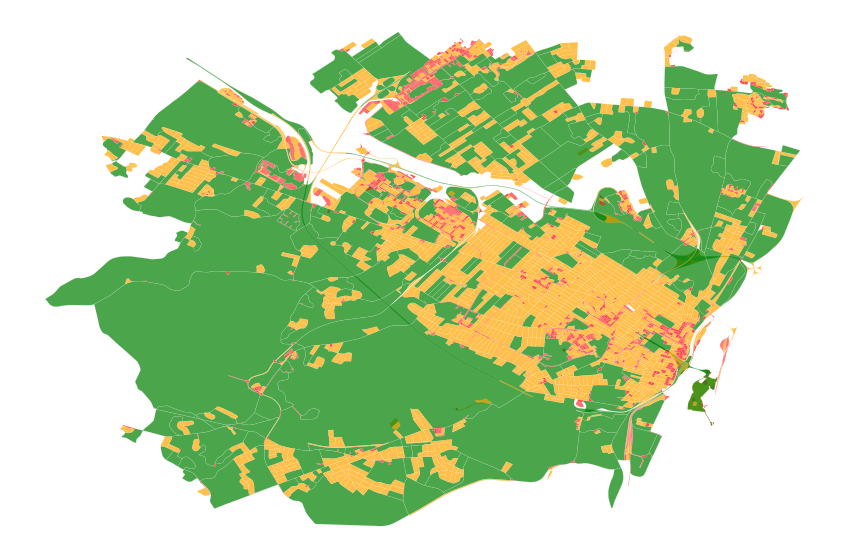

In [23]:
# Using the rel_multi polygon for visualization
fig, axs = plt.subplots(figsize=(15, 10))

count = 0
# Plotting the polygons with appropriate colors
for geom in rel_multi.geoms:    
    xs, ys = geom.exterior.xy
    if color_relabel[count] == 0:
        axs.fill(xs, ys, alpha=0.7, fc='red', ec='white', linewidth=0.05)
    elif color_relabel[count] == 1:
        axs.fill(xs, ys, alpha=0.7, fc='orange', ec='white', linewidth=0.1)
    else:
        axs.fill(xs, ys, alpha=0.7, fc='green', ec='white', linewidth=0.15)
    count += 1

axs.axis('off')  # This line removes the axis
plt.show()

## Construct the Voronoi map from Polygons

Here we obtain the centroids of the polygons, then we apply **voronoi_finite_polygons_2d** to obtain the voronoi regions from that centroids. We then obtain the voronoi polygons.

In [24]:
centroids = []  # This list's length will be equal to the number of city polygons

# Calculating the centroids of the polygons
for i in range(0, len(relabel)):
    current_centroid = [relabel[i].centroid.x, relabel[i].centroid.y]
    centroids.append(current_centroid)

# Collecting points from a series of polygons
points = np.array(centroids)
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Creating a convex hull mask
pts = MultiPoint([Point(i) for i in points])
mask = pts.convex_hull
new_vertices = []

# Adjusting the vertices based on the mask
for region in regions:
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    new_vertices.append(poly)
    
all_polygons = []

# Converting vertices to polygons
for vertices in new_vertices:
    poly = Polygon(vertices)
    all_polygons.append(poly)

rel_vor_multi = MultiPolygon(all_polygons)

## Assign the colour to the Voronoi Polygons.

Here we create a list with the colour assigned to each of the voronoi polygon. We use the same rule as for the real polygons: small areas are coloured with **red**, medium areas are coloured with **orange** and large areas are coloured with **green**.

In [11]:
color_vor = []

# Opening and reading the file containing the color ID data
with open("/Users/dayantur/Documents/CityProject/VorCol/id_col_"+current_city+".txt") as fp:
    for line in fp:
        line = line.split(" ")
        color_vor.append(int(line[1]))

## Plot the Voronoi coloured mapping

We are now ready to plot the Voronoi coloured mapping.

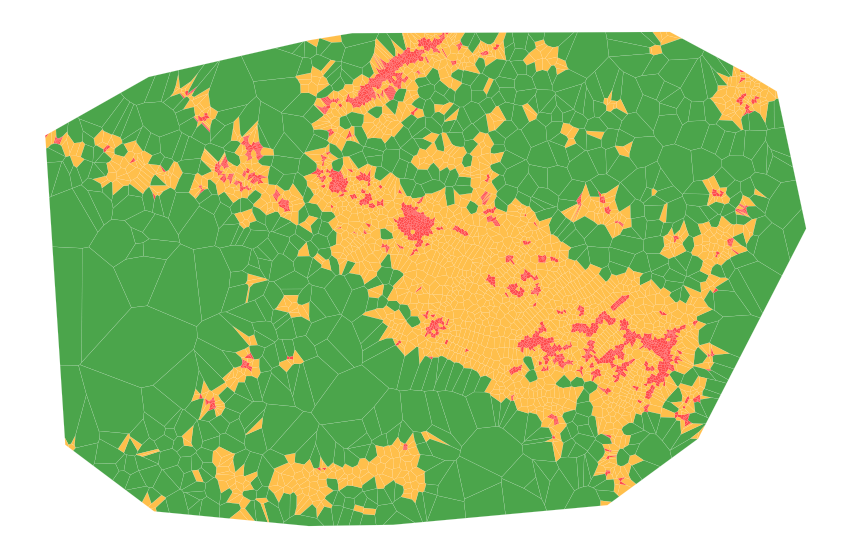

In [15]:
# Using the rel_vor_multi polygon for visualization
fig, axs = plt.subplots(figsize=(15, 10))

count = 0
# Plotting the polygons with appropriate colors
for geom in rel_vor_multi.geoms:    
    xs, ys = geom.exterior.xy
    if color_vor[count] == 0:
        axs.fill(xs, ys, alpha=0.7, fc='red', ec='white', linewidth=0.05)
    elif color_vor[count] == 1:
        axs.fill(xs, ys, alpha=0.7, fc='orange', ec='white', linewidth=0.1)
    else:
        axs.fill(xs, ys, alpha=0.7, fc='green', ec='white', linewidth=0.15)
    count += 1

axs.axis('off')  # This line removes the axis
plt.show()